<h1 align="center"> Practical Class 3: Linear and Non-linear Errors in DACs and ADCs </h1>

<p align="justify">
The introduction of quantization noise in the ADC or DAC introduces errors 
associated with the quantization step size defining the true characteristic 
of the ADC or DAC transfer function. This notebook presents the modelling and 
study of the two main types of errors in converters: linear and non-linear.
</p>

In [76]:
# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram
from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

<h2 align="center"> 1. DAC Errors Modelling </h2>

<h3 align="center"> 1.1. DAC Linear Errors </h3>
<p align="justify"> 
This section presents the modelling of the linear errors that arise when modelling the transfer function of a DAC. These errors relate to a deviation of the real transfer function of the DAC towards the ideal DAC's transfer function, in which each step size is exactly the same height!
</p>

In [77]:
# define the DAC 
vref = 1.0 # define the reference voltage [V]
n_bits = 5 # define the number of bits of the DAC
vlsb = vref/(2**n_bits) # compute the fundamental step voltage between quantized levels
# define an ideal DAC to compare the results
idac = ideal_dac(vref, n_bits)
# define a DAC with offset error
voff = 0.05
dac_off = lambda x: idac(x) + voff
# define a DAC with end of scale error
# note that the end of scale error 
# is actually directly related to
# the gain error of the DAC
gain_err = -0.1
target_gain = 1.0 + gain_err
dac_eos = lambda x: idac(x)*target_gain
# define a DAC with offset and end of scale error
# to measure the true DAC gain error
dac_off_eos = lambda x: idac(x)*target_gain + voff
# define the input codes of the 3 DACs
din = np.arange(2**n_bits)
# convert the decimals to input binary words
dinb = dec2bin(din, n_bits)
# create the string representation of the input codes
dinb_str = [ "".join([str(num) for num in xv]) for xv in dinb]
# compute the output voltages of the 3 DACs
vout = idac(dinb)
vout_off = dac_off(dinb)
vout_eos = dac_eos(dinb)
vout_off_eos = dac_off_eos(dinb)

<p align="justify">
To accurately measure the linear error of DACs it is only necessary to observe the initial and final points of the transfer function. From these points three measurements can be performed:
<ul>
<li>Offset Error, represented in Eq.(1)</li>
<li>End of Scale Error, represented in Eq.(2)</li>
<li>Gain Error, represented in Eq.(3)</li>
</ul>

The Gain Error of the DAC is directly related to both the End of Scale and Offset Errors of the DAC and is derived from them. The errors are measured in LSB units.
</p>

$$\epsilon_{OFF} = \frac{V_{OUT}'[T_0] - V_{OUT}[T_0]}{V_{LSB}} \hspace{4 pt} [LSB] \hspace{10 pt} (1)$$

$$\epsilon_{EOS} = \frac{V_{OUT}'[T_{2^N - 1}] - V_{OUT}[T_{2^N - 1}]}{V_{LSB}} \hspace{4 pt} [LSB] \hspace{10 pt} (2)$$

$$GER_{[\%]} = \left(\frac{V_{OUT}'[T_{2^N - 1}] - V_{OUT}'[T_{0}]}{V_{OUT}[T_{2^N - 1}] - V_{OUT}[T_{0}]} - 1\right)\times100 \hspace{10 pt} (3)$$

where $V_{OUT}[T_i]$ and $V_{OUT}'[T_i]$ is the output voltage of the ideal DAC and real DAC at the $i^{th}$ transition, respectively.

In [78]:
# measure the DAC errors
eoff = (vout_off_eos[0] - vout[0])/vlsb
eeos = (vout_off_eos[2**n_bits - 1] - vout[2**n_bits - 1])/vlsb
ger_pct = ((vout_off_eos[2**n_bits - 1] - vout_off_eos[0])/(vout[2**n_bits - 1] - vout[0]) - 1)*100
print("The offset error is {:.2f} LSB".format(eoff))
print("The end of scale error is {:.2f} LSB".format(eeos))
print("The gain error is {:.2f} %".format(ger_pct))

The offset error is 1.60 LSB
The end of scale error is -1.50 LSB
The gain error is -10.00 %


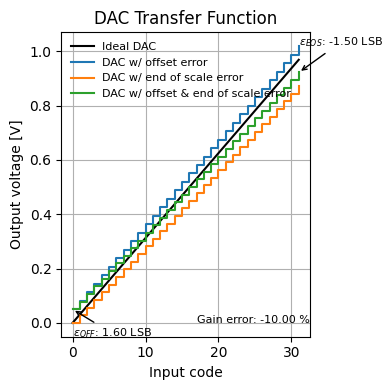

In [79]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(din,vout, label="Ideal DAC", marker="None", mfc="None", color="k")
ax.step(din,vout_off, where="post", label="DAC w/ offset error")
ax.step(din,vout_eos, where="post", label="DAC w/ end of scale error")
ax.step(din,vout_off_eos, where="post", label="DAC w/ offset & end of scale error")
ax.set_xlabel("Input code")
ax.set_ylabel("Output voltage [V]")
#ax.set_xticks(din)
#ax.set_xticklabels(dinb_str, rotation=45)
ax.grid(True)
ax.set_title("DAC Transfer Function")
ax.legend(fontsize=8, fancybox=False, frameon=False)
# annotate the DAC errors on the plot
ax.annotate(r"$\epsilon_{OFF}$: "+"{:.2f} LSB".format(eoff), xy=(0, vout_off_eos[0]), xytext=(0, vout_off_eos[0] - 0.1), arrowprops=dict(arrowstyle="->"), fontsize=8)
ax.annotate(r"$\epsilon_{EOS}$: "+"{:.2f} LSB".format(eeos), xy=(2**n_bits - 1, vout_off_eos[2**n_bits - 1]), xytext=(2**n_bits - 1, vout_off_eos[2**n_bits - 1] + 0.1), arrowprops=dict(arrowstyle="->"), fontsize=8)
# add an arrow showing the difference between the ideal DAC and the DAC with offset and end of scale error
ax.annotate("Gain error: {:.2f} %".format(ger_pct), xy=(0,0), xytext=(2**n_bits - 15, 0), fontsize=8)
fig.tight_layout()

<h3 align="center"> 1.2. DAC Non-Linear Errors </h3>
<p align="justify"> 
This section presents the modelling of the non-linear errors that arise when modelling the transfer function of a DAC. These errors relate to a deviation of the real transfer function of the DAC towards the ideal DAC's transfer function, in which each step size can differ in height due to the inherent non-linearity that arises when quantizing a noisy signal!
</p>

In [80]:
# define the DAC 
vref = 1.0 # define the reference voltage [V]
n_bits = 4 # define the number of bits of the DAC
vlsb = vref/(2**n_bits) # compute the fundamental step voltage between quantized levels
# define an ideal DAC to compare the results
idac = ideal_dac(vref, n_bits)
# define the noise signal with a uniform distribution
vq_var = (vlsb**2)/12
vq_std_dev = np.sqrt(vq_var)
noise_factor=2
dac_nonlinear = lambda x: idac(x) + noise_factor*uniform(-vq_std_dev, vq_std_dev, len(x))
#dac_nonlinear = lambda x: idac(x) + normal(loc=0, scale=vq_std_dev, size=len(x))
# define the input codes of the DAC
din = np.arange(2**n_bits)
# convert the decimals to input binary words
dinb = dec2bin(din, n_bits)
# create the string representation of the input codes
dinb_str = [ "".join([str(num) for num in xv]) for xv in dinb]
# compute the output voltages of the DAC
vout = idac(dinb)
vout_nonlinear = dac_nonlinear(dinb)

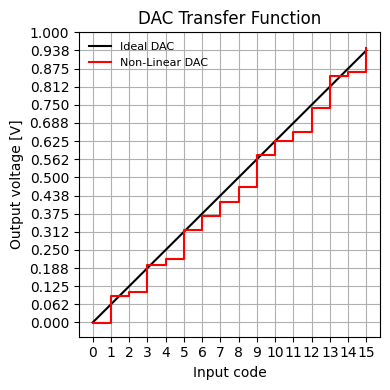

In [81]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(din,vout, label="Ideal DAC", marker="None", mfc="None", color="k")
#ax.step(din,vout, where="post", label="Ideal DAC", color="b")
ax.step(din,vout_nonlinear, where="post", label="Non-Linear DAC", color="r")
ax.set_xticks(din)
ax.set_yticks(np.arange(0, vref + vlsb, vlsb))
ax.set_xlabel("Input code")
ax.set_ylabel("Output voltage [V]")
ax.set_title("DAC Transfer Function")
ax.legend(fontsize=8, fancybox=False, frameon=False)
ax.grid(True)
fig.tight_layout()

<p align="justify">
As it is possible to observe, the exagerated transfer function non-linearities represented in the plot above feature variable output voltages for the non-ideal DAC, due to the quantization noise. The noise was multiplied by an amplification factor to better observe the effect of the quantization noise in the non-linear behaviour of the DAC's transfer function.
</p>

<p align="justify">
The non-linear errors of converters can come in two forms:
<ul>
<li>Differential Non-Linearity (DNL), given in Eq.(5),</li>
<li>Integral Non-Linearity (INL), given in Eq.(6).</li>
</ul>

The DNL and INL are measured in LSB units. The DNL provides a method of locally observing how much each step size changes in each transition. The INL on the other hand is the accumulation of the DNL up until the respective transition, and enables the measurement of the global step-size variability throughout every transition of the transfer function. In DACs, the INL and DNL, as well as any other kind of error, are measured in the vertical axis, where the voltage unit is. Eq. (4) presents the actual measured least significant bit step voltage of the DAC.
</p>

$$ V_{LSB}' = \frac{V_{OUT}'[2^N - 1] - V_{OUT}'[0]}{2^N - 1} \hspace{4 pt} [V] \hspace{10 pt} (4)$$

$$ DNL[n] = \frac{V_{OUT}'[n+1] - V_{OUT}'[n]}{V_{LSB}'} \hspace{4 pt} [LSB], n\in [0, 2^N-2] \hspace{10 pt} (5) $$

$$ INL[n] = \frac{V_{OUT}'[n] - n\times V_{LSB}' - V_{OUT}'[0]}{V_{LSB}'} \hspace{4 pt} [LSB], n\in [0, 2^N-1] \hspace{10 pt} (6) $$

where $V_{OUT}'[n]$ is the output voltage of the real DAC at the $n^{th}$ transition and $V_{LSB}'$ is the measured step size of the non-ideal DAC.

<p align="justify">
<b>NOTE:</b> The INL and DNL can only be calculated after removing the linear error sources (offset, and gain errors).
</p>

The ideal vlsb is 0.0625 V
The measured vlsb is 0.0632 V


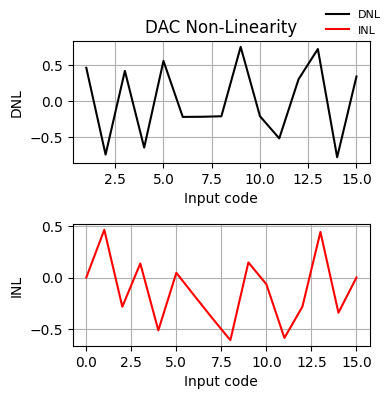

In [82]:
# measure the real vlsb
vlsb_measured = (vout_nonlinear[2**n_bits - 1] - vout_nonlinear[0])/(2**n_bits - 1)
print("The ideal vlsb is "+"{:.4f} V".format(vlsb))
print("The measured vlsb is "+"{:.4f} V".format(vlsb_measured))
# measure the DNL of the DAC
dnl = (vout_nonlinear[1::] - vout_nonlinear[0:-1])/vlsb_measured - 1
dnl_pythonic = np.diff(vout_nonlinear)/vlsb_measured - 1
assert np.allclose(dnl, dnl_pythonic), "The DNL two methods give different results"
# assert that n is in [0, 2**n_bits-2] for the DNL
assert len(dnl) == 2**n_bits - 1, "The DNL has a wrong length"
idx = np.arange(2**n_bits)
inl = (vout_nonlinear - idx*vlsb_measured - vout_nonlinear[0])/vlsb_measured
# assert that n is in [0, 2**n_bits-1] for the INL
assert len(inl) == 2**n_bits, "The INL has a wrong length"
# plot the results
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(din[1::], dnl, label="DNL", marker="None", mfc="None", color="k")
ax[1].plot(din, inl, label="INL", marker="None", mfc="None", color="r")
ax[0].set_xlabel("Input code")
ax[1].set_xlabel("Input code")
ax[0].set_ylabel("DNL")
ax[1].set_ylabel("INL")
ax[0].set_title("DAC Non-Linearity")
ax[0].grid(True)
ax[1].grid(True)
fig.tight_layout()
fig.legend(fancybox=False, frameon=False, fontsize=8)

<h2 align="center"> 2. ADC Error Modelling  </h2>

<h3 align="center"> 2.1. ADC Linear Errors </h3>
<p align="justify"> 
This section presents the modelling of the linear errors that arise when modelling the transfer function of a ADC. These errors relate to a deviation of the real transfer function of the ADC towards the ideal ADC's transfer function, in which each step size is exactly the same width!
It is important to note that in this case (ADC), it is the transition voltlallges of the ADC that deviate from ideal ones, without ever changing step size!
</p>

In [83]:
# define the ADC 
vref = 1.0 # define the reference voltage [V]
n_bits = 4 # define the number of bits of the DAC
vlsb = vref/(2**n_bits) # compute the fundamental step voltage between quantized levels
# define an ideal DAC to compare the results
roundf = np.round
iadc = ideal_adc(vref, n_bits, roundf)
# define the non-ideal ADC with linear errors
# to procees with this step, we need to define 
# an ADC modelling function that is closer to the 
# its physical implementation - the model should include
# the transition voltages as a characteristic parameter
# and the input voltage will only provoke a transition
# if the input voltage is greater than the corresponding
# transition voltage
# define an ADC with offset error
voff = 0.05
adc_off, vt_off = nonideal_adc(vref, n_bits, roundf=roundf, ofst=voff)
# define a DAC with end of scale error
# note that the end of scale error 
# is actually directly related to
# the gain error of the DAC
gain_err = -0.1
target_gain = 1.0 + gain_err
adc_eos, vt_eos = nonideal_adc(
    vref, n_bits, roundf=roundf, gain=target_gain)
# define a DAC with offset and end of scale error
# to measure the true DAC gain error
adc_off_eos, vt_off_eos = nonideal_adc(
    vref, n_bits, roundf=roundf, ofst=voff, gain=target_gain)
# define the input voltages of the ADC
vin = np.arange(0, vref+vlsb, vlsb)
vt_off = np.concatenate(([0], vt_off, [vt_off[-1]]))
vt_eos = np.concatenate(([0], vt_eos, [vt_eos[-1]]))
vt_off_eos = np.concatenate(([0], vt_off_eos, [vt_off_eos[-1]]))
# create the string representation of the input codes
# compute the output voltages of the 3 DACs
dout = iadc(vin)
dout_off = adc_off(vin)
dout_eos = adc_eos(vin)
dout_off_eos = adc_off_eos(vin)
# convert the output codes to decimals
dout_dec = bin2dec(dout, n_bits)
dout_off_dec = bin2dec(dout_off, n_bits)
dout_eos_dec = bin2dec(dout_eos, n_bits)
dout_off_eos_dec = bin2dec(dout_off_eos, n_bits)

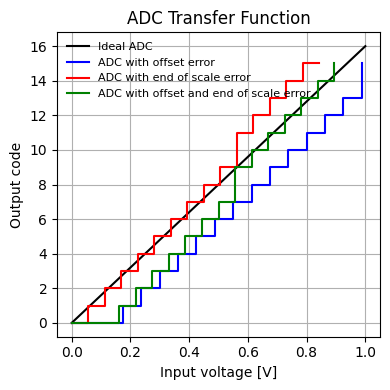

In [84]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(vin, dout_dec, label="Ideal ADC", marker="None", mfc="None", color="k")
ax.step(vt_off, dout_off_dec,where="post", label="ADC with offset error", color="b")
ax.step(vt_eos, dout_eos_dec, where="post", label="ADC with end of scale error", color="r")
ax.step(vt_off_eos, dout_off_eos_dec, where="post", label="ADC with offset and end of scale error", color="g")
ax.set_xlabel("Input voltage [V]")
ax.set_ylabel("Output code")
ax.set_title("ADC Transfer Function")
ax.legend(fontsize=8, fancybox=False, frameon=False)
ax.grid(True)
fig.tight_layout()

In [85]:
# compute linear error ratios
e_off = (vout_off_eos[0] - vin[0])/vlsb
e_eos = (vout_off_eos[-1] - vin[-1])/vlsb
ger_pct = ((vout_off_eos[-1] - vout_off_eos[0])/(vin[-1] - vin[0]) - 1)*100
print("The offset error is "+"{:.2f} LSB".format(e_off))
print("The end of scale error is "+"{:.2f} LSB".format(e_eos))
print("The gain error is "+"{:.2f} %".format(ger_pct))

The offset error is 0.80 LSB
The end of scale error is -1.25 LSB
The gain error is -12.81 %


<h3 align="center"> 2.2. ADC Non-Linear Errors </h3>
<p align="justify"> 
This section presents the modelling of the non-linear errors that arise when modelling the transfer function of a ADC. These errors relate to a deviation of the real transfer function of the ADC towards the ideal ADC's transfer function, in which each step size can differ in width due to the inherent non-linearity that arises when quantizing a noisy signal! In a physical implementation, the intrinsic non-linearities that devices present are usually the main source of non-linear errors in ADCs, directly affecting the position of the transition voltages of the ADC.
</p>

In [86]:
# define the ADC 
vref = 1.0 # define the reference voltage [V]
n_bits = 5 # define the number of bits of the DAC
vlsb = vref/(2**n_bits) # compute the fundamental step voltage between quantized levels
roundf = np.round
# define an ideal DAC to compare the results
iadc = ideal_adc(vref, n_bits, roundf)
# define the noise signal with a uniform distribution
vq_var = (vlsb**2)/12
vq_std_dev = np.sqrt(vq_var)
noise_factor=2
adc_nonlinear, vtrans = nonideal_adc(
    vref, n_bits, roundf=roundf,
    vnq=noise_factor*vq_std_dev)
# define the input voltages of the ADC
vin = np.arange(0, vref+vlsb, vlsb)
# compute the output codes of the ADC
dout = bin2dec(iadc(vin), n_bits)
dout_nonlinear = bin2dec(adc_nonlinear(vin), n_bits)

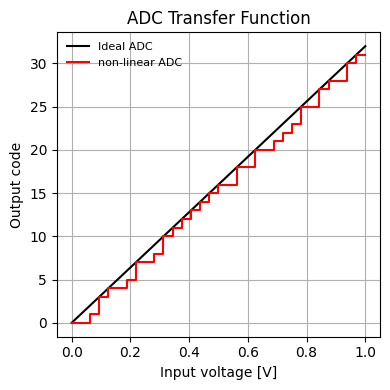

In [87]:
# plot the results
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(vin, dout, label="Ideal ADC", marker="None", mfc="None", color="k")
ax.step(vin, dout_nonlinear, where="post", label="non-linear ADC", color="r")
ax.set_xlabel("Input voltage [V]")
ax.set_ylabel("Output code")
ax.set_title("ADC Transfer Function")
ax.legend(fontsize=8, fancybox=False, frameon=False)
ax.grid(True)
fig.tight_layout()

<p align="justify">
From both figures observed in this ADC section (2.1 and 2.2),
a very important conclusion can be taken: both linear and non-linear errors can lead to missing codes in the output of the ADC, which eventually leads to a loss of effective resolution of the converter.
</p>

<p align="justify">
Analogously to the DAC section, the non-linear errors of converters can come in two forms:
<ul>
<li>Differential Non-Linearity (DNL), given in Eq.(8),</li>
<li>Integral Non-Linearity (INL), given in Eq.(9).</li>
</ul>

The DNL and INL are measured in LSB units. The DNL provides a method of locally observing how much each step size changes in each transition voltage. The INL on the other hand is the accumulation of the DNL up until the respective transition, and enables the measurement of the global transition voltage step-size variability throughout every transition of the transfer function. In ADCs, the INL and DNL, as well as any other kind of error, are measured in the horizontal axis, where the voltage unit is. Eq. (7) presents the actual measured least significant bit step voltage of the ADC.
</p>

$$ V_{LSB}' = \frac{V_{T}'[2^N - 1] - V_{T}'[1]}{2^N - 2} \hspace{4 pt} [V] \hspace{10 pt} (7)$$

$$ DNL[n] = \frac{V_{T}'[n+1] - V_{T}'[n]}{V_{LSB}'} \hspace{4 pt} [LSB], n\in [0, 2^N-3] \hspace{10 pt} (8) $$

$$ INL[n] = \frac{V_{T}'[n] - n\times V_{LSB}' - V_{T}'[1]}{V_{LSB}'} \hspace{4 pt} [LSB], n\in [0, 2^N-2] \hspace{10 pt} (9) $$

where $V_{T}'[n]$ is the transition voltage level of the real ADC at the $n^{th}$ transition and $V_{LSB}'$ is the measured least significant bit step size of the non-ideal ADC.

In this case (ADC), there are $2^N$ intervals, but only $2^N - 1$ transition voltages, whereas in the DAC case there are $2^N$ intervals and $2^N$ output voltages

<p align="justify">
<b>NOTE:</b> The INL and DNL can only be calculated after removing the linear error sources (offset, and gain errors).
</p>

In [88]:
# compute the non linearity of the ADC
# compute the measured vlsb
assert len(vtrans) == 2**n_bits - 1
vlsb_measured = (vtrans[-1] - vtrans[0])/(len(vtrans)-1)
print("The ideal vlsb is "+"{:.4f} V".format(vlsb))
print("The measured vlsb is "+"{:.4f} V".format(vlsb_measured))
# compute the DNL
dnl = np.diff(vtrans)/vlsb_measured - 1
# assert that n is in [0, 2**n_bits-3] for the DNL
assert len(dnl) == 2**n_bits - 2, "The number of DNL values is not correct"
# compute the INL
idx = np.arange(0, len(vtrans), 1)
inl = (vtrans - idx*vlsb_measured - vtrans[0])/vlsb_measured
# assert that n is in [0, 2**n_bits-2] for the INL
assert len(inl) == 2**n_bits - 1, "The number of INL values is not correct"

The ideal vlsb is 0.0312 V
The measured vlsb is 0.0307 V


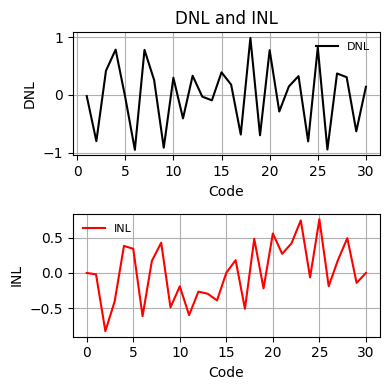

In [89]:
codest = np.arange(1, len(vtrans), 1) # define the DNL transition codes
# plot the results
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(codes, dnl, label="DNL", marker="None", mfc="None", color="k")
ax[1].plot(idx, inl, label="INL", marker="None", mfc="None", color="r")
ax[0].set_xlabel("Code")
ax[0].set_ylabel("DNL")
ax[1].set_xlabel("Code")
ax[1].set_ylabel("INL")
ax[0].set_title("DNL and INL")
ax[0].legend(fontsize=8, fancybox=False, frameon=False)
ax[1].legend(fontsize=8, fancybox=False, frameon=False)
ax[0].grid(True)
ax[1].grid(True)
fig.tight_layout()